# Bored Ape Yacht Club Value Estimation

The motivation for this work is to develop a reasonable model that can estimate the value of BAYC NFT. 

There are two goals:

1. Through the process of feature selection we can better understand what properties of the NFTS are predictive with respect to value.
2. Create a criterion for labeling 'undervalued' NFTs when new sales in the OpenSea market arrive.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# display formatting for floats
pd.options.display.float_format = '{:,.6f}'.format

In [3]:
df = pd.read_csv('bored_apes.csv', parse_dates=['SaleDate']).rename(columns={'index': 'TokenId'})
# Bored Ape #225 has a sale of 0 USD (transfer to same owner with address labelled Vault)
# not sure why transfer style activity sometimes gets labelled as a sale
df = df.loc[df['USDPrice'] != 0]
df = df.sort_values(['SaleDate'])  # sort by sale date and time

We want to determine value of an NFT, which changes over time of course. A possible target can be the extension from a robust moving average (since there are a lot of outliers in the data).

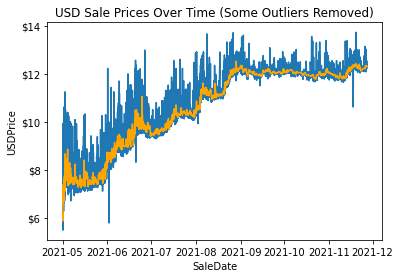

In [4]:
ts = df.groupby('SaleDate').agg({'USDPrice': 'mean'})
ts_outrm = ts.loc[ts['USDPrice'] < 10e5]
# Rolling median for outlier robustness
log_price = np.log(ts_outrm['USDPrice'])
rolling_median = log_price.rolling(window=14).median()

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter('${x:,.0f}')
sns.lineplot(x='SaleDate', y=log_price, data=ts_outrm)
sns.lineplot(x=ts_outrm.index, y=rolling_median, color='orange') \
    .set_title('USD Sale Prices Over Time (Some Outliers Removed)')
plt.show()

The rolling mean is not as robust to influence from outliers as other methods. Below I'll try to create another rolling estimator of a 'base' price. It will remove outliers as defined through rolling mean and standard deviation. Then I'll fill those outliers with the previous values (**just to create the rolling baseline**)

Rolling Median with window 7
EWM span 7

In [5]:
# rolling_median = df['USDPrice'].rolling(window=3, min_periods=1).median()
# ewm = df['USDPrice'].ewm(span=3).mean()
# df['USDPriceEWM'] = (rolling_median + ewm) / 2

In [6]:
# df.loc[df['TokenId']==8029, ['USDPrice', 'USDPriceEWM', 'SaleDate']]

In [7]:
df['LogUSDPrice'] = np.log(df['USDPrice'])

In [8]:
mean = df['LogUSDPrice'].ewm(span=14).mean()  # exponentially weighted moving average with 14 point window
std = df['LogUSDPrice'].ewm(span=14).std()

mean_plus_std = mean + 1.7*std  # 1.7 worked well
# mean_minus_std = mean - 2*std

# is_outlier = (df['LogUSDPrice'] > mean_plus_std) | (df['LogUSDPrice'] < mean_minus_std)
is_outlier = df['LogUSDPrice'] > mean_plus_std
df['Outlier'] = 1
df.loc[is_outlier, 'Outlier'] = -1

# rolling_median = df['LogUSDPrice'].rolling(window=7, min_periods=1).median()
# ewm = df['LogUSDPrice'].ewm(span=14).mean()
# df['LogUSDPriceEWM'] = (rolling_median + ewm) / 2
# # Percentage Extension from the Exponential Weighted Moving Average
# df['PctExtensionEWM'] = df.apply(lambda x: (x['LogUSDPrice'] - x['LogUSDPriceEWM']) / x['LogUSDPriceEWM'], axis=1)

In [9]:
dfo, dfi = df[is_outlier].copy(), df[~is_outlier].copy()
dfs = dfo, dfi
for data in dfs:
    rolling_median = data['LogUSDPrice'].rolling(window=7, min_periods=1).median()
    ewm = data['LogUSDPrice'].ewm(span=14).mean()
    data['LogUSDPriceEWM'] = (rolling_median + ewm) / 2
    # Percentage Extension from the Exponential Weighted Moving Average
    data['PctExtensionEWM'] = data.apply(lambda x: (x['LogUSDPrice'] - x['LogUSDPriceEWM']) / x['LogUSDPriceEWM'], axis=1)

**Results** (over the origin dataset)

<AxesSubplot:xlabel='SaleDate', ylabel='LogUSDPrice'>

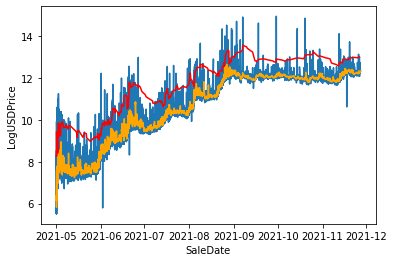

In [10]:
sns.lineplot(x='SaleDate', y='LogUSDPrice', data=df)
sns.lineplot(x='SaleDate', y='LogUSDPriceEWM', color='orange', data=dfi)
sns.lineplot(x='SaleDate', y='LogUSDPriceEWM', color='red', data=dfo)

## Handling Missing Data

To handle the NaNs contained in the traits columns, we can simply **calculate their rarity using the non-missing data**.

In [11]:
rarity_cols = [c for c in df.columns if 'Rarity' in c]  # get all numeric rarity related cols
# clean up na's in rarity cols
def fill_trait_na(col) -> float:
    """Calculate the missing data in trait rarity columns"""
    fill_value = 1 - col.dropna().unique().sum()
    return fill_value

for data in dfs:
    data[rarity_cols] = data[rarity_cols].apply(lambda x: x.fillna(fill_trait_na(x)))

Change NaNs to None. This way it represents an actual category (not having a hat for example).

In [12]:
traits = ['Background', 'Earring', 'Fur', 'Eyes', 'Mouth', 'Clothes', 'Hat']
for data in dfs:
    data[traits] = data[traits].fillna('None')

## Engineering a couple new features

It could be valuable for the ape to have **matching** properties. We will create a column for the greatest number of matching properties:

In [13]:
def has_two_less_1pct(row, cols):
    """Retruns true if the NFT has at least two traits with rarities less than 1%"""
    rarity = row[cols].values
    n = len(rarity[np.where(rarity < 0.01)])
    if n> 1:
        return 1
    return 0

def has_rare_clothes_or_fur(row):
    """Return true if the NFT has clothes or fur with a rarity of less than 1%"""
    if row['ClothesRarity'] < 0.01 or row['FurRarity'] < 0.01:
        return 1
    return 0

def has_blacksuit_or_gold_fur(row):
    """Return true if the NFT has Black Suit for clothes or Solid Gold fur"""
    if row['Clothes'] == 'Black Suit' or row['Fur'] == 'Solid Gold':
        return 1
    return 0

from collections import Counter
def find_matches(row, categories):
    traits = row[categories].values
    keywords = []
    for trait in traits:
        split = trait.split(' ')
        for word in split:
            keywords.append(word)
    if 'None' in keywords:
        keywords.remove('None')
    counts = Counter(keywords)
    most_common = counts.most_common(1)
    matches = most_common[0][1] - 1
    if matches:
        return 1
    return 0

for data in dfs:
    data['HasTwoLess1Pct'] = data.apply(lambda x: has_two_less_1pct(x, rarity_cols), axis=1)
    data['HasRareClothesOrFur'] = data.apply(has_rare_clothes_or_fur, axis=1)
    data['HasBlackSuitOrGoldFur'] = data.apply(has_blacksuit_or_gold_fur, axis=1)
    data['HasMatches'] = data.apply(lambda x: find_matches(x, traits), axis=1)

Decision rule for guessing an outlier

In [14]:
for data in dfs:
    data.loc[(data['HasTwoLess1Pct']==1) | (data['HasRareClothesOrFur']==1) | (data['HasBlackSuitOrGoldFur']==1), 'OutlierRule'] = -1
    data['OutlierRule'] = data['OutlierRule'].fillna(1)

In [15]:
# from sklearn.metrics import confusion_matrix
# y_true, y_pred = df['Outlier'], df['OutlierRule']
# confm = confusion_matrix(y_true, y_pred)
# print(confm)
# TP, FP, FN, TN = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
# acc = (TP + TN) / (TP + FP + FN + TN)
# recall = TP / (TP + FN)
# prec = TP / (TP + FP)
# f1 = 2 / (1/recall + 1/prec)
# print("Accuracy: ", acc)
# print("Recall: ", recall)
# print("Preceision: ", prec)
# print("F1 Score: ", f1)

## Data Preprocessing

In [16]:
from sklearn.preprocessing import OneHotEncoder

To prepare the data for the model we will need to do some scaling and normalizing of the target variable and create numerical features for the training data through encoding.

### Scaling and Normalizing Target

Text(0.5, 1.0, 'Distribution of Extension from EWM Outliers')

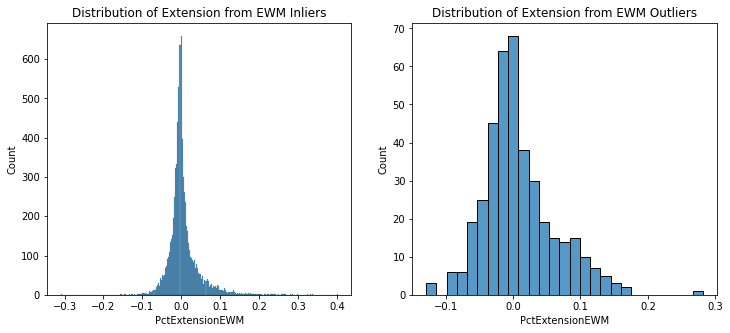

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
sns.histplot(dfi['PctExtensionEWM'], ax=ax1)
ax1.set_title('Distribution of Extension from EWM Inliers')
sns.histplot(dfo['PctExtensionEWM'], ax=ax2)
ax2.set_title('Distribution of Extension from EWM Outliers')

### Encoding Categorical Features

In [18]:
categorical_feature_cols = [
    'Background',
    'Earring',
    'Mouth',
    'Clothes',
    'Hat',
    'Fur',
    'Eyes',
]
clf_features = ['HasTwoLess1Pct', 'HasRareClothesOrFur', 'HasBlackSuitOrGoldFur', 'HasMatches']

In [19]:
# encode outlier data
enc = OneHotEncoder(handle_unknown='ignore')

# regression encoded dataframe
enc_df = pd.DataFrame(enc.fit_transform(dfo[categorical_feature_cols]).toarray())

# add labels
enc_df.columns = enc.get_feature_names_out()

# merge and drop
dfp = pd.concat([dfo, enc_df], axis=1, join="inner") # concatente encoded df
dfo = dfp.drop(columns=categorical_feature_cols)

In [20]:
# encode inlier data
enc = OneHotEncoder(handle_unknown='ignore')

# regression encoded dataframe
enc_df = pd.DataFrame(enc.fit_transform(dfi[categorical_feature_cols]).toarray())

# add labels
enc_df.columns = enc.get_feature_names_out()

# merge and drop
dfp = pd.concat([dfi, enc_df], axis=1, join="inner") # concatente encoded df
dfi = dfp.drop(columns=categorical_feature_cols)

In [21]:
exclude_features = [
    'TokenId', 'LastSalePrice', 'LastSaleToken',
    'SaleDate', 'USDPrice', 'USDPriceEWM', 'PctExtensionEWM',
    'Outlier', 'LogUSDPrice', 'LogUSDPriceEWM', 'OutlierRule',
    'NumberOfSales'
]
exclude_features.extend(clf_features)
# remove the rarity features since they are completely correlated with the categoricals
exclude_features.extend([feature for feature in df.columns if 'Rarity' in feature])
features = [feature for feature in df.columns if feature not in exclude_features]

## Modeling

In [22]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, HuberRegressor, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [23]:
df = pd.concat([dfi, dfo])

In [24]:
features = [feature for feature in df.columns if '_' in feature]

In [25]:
X = df.loc[:, features+['OutlierRule', 'Outlier']]
y = df['PctExtensionEWM']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
X_train_in = X_train[X_train['Outlier']==1].drop(columns=['OutlierRule', 'Outlier'])
y_train_in = y_train[X_train['Outlier']==1]

In [27]:
X_train_out = X_train[X_train['Outlier']==-1].drop(columns=['OutlierRule', 'Outlier'])
y_train_out = y_train[X_train['Outlier']==-1]

### Model Selection

In [28]:
from typing import List
def model_selection(models: List[dict], scores: List[str], X_train, y_train) -> dict:
    """Find the best model"""
    results = {}
    for candidate in models:
        model = GridSearchCV(
            candidate['constructor'], param_grid=candidate['param_grid'], scoring=scores
        )
        model.fit(X_train, y_train)
        mean_test_score = model.cv_results_['mean_test_score'].mean()
        results[candidate['name']] = mean_test_score
    print("The winner is: {}".format(
        max(results, key=results.get)
    ))
    return results

In [29]:
models = [
    {
        'name': 'LinearRegression',
        'constructor': LinearRegression(),
        'param_grid': {}
    },
    {
        'name': 'RandomForest',
        'constructor': RandomForestRegressor(random_state=0),
        'param_grid': {}
    },
    {
        'name': 'Huber',
        'constructor': HuberRegressor(),
        'param_grid': {'epsilon': [10], 'max_iter': [1000]}
    }
]
model_selection(models, 'neg_root_mean_squared_error', X_in_train, y_in_train)

NameError: name 'X_in_train' is not defined

## Stacking

In [ ]:
from sklearn.ensemble import VotingRegressor

In [ ]:
estimators = [('randomforest', RandomForestRegressor(random_state=42)),
              ('linear', LinearRegression()),
              ('huber', HuberRegressor(epsilon=10, max_iter=800))]

In [ ]:
vreg_in, vreg_out = VotingRegressor(estimators),  VotingRegressor(estimators)

In [ ]:
# cross_validate(ereg, X_in_train, y_in_train, cv=3,
#                scoring=('neg_mean_squared_error'),
#                return_train_score=True)

In [ ]:
vreg_in.fit(X_train_in, y_train_in)
vreg_out.fit(X_train_out, y_train_out)

In [ ]:
def predict(X, models: dict):
    """Custom prediction function to combine two regression models"""
    outliers = X['OutlierRule'] == -1
    X_o = X.loc[outliers].drop(columns=['OutlierRule', 'Outlier'])
    X_i = X.loc[~outliers].drop(columns=['OutlierRule', 'Outlier'])
    y = np.empty(X.shape[0])  # store combined predictions
    # predict target values separately accorindg to the two models
    
    if X_o.shape[0]:
        y_o_pred = models['o'].predict(X_o)
        y[outliers] = y_o_pred
    if X_i.shape[0]:
        y_i_pred = models['i'].predict(X_i)
        y[~outliers] = y_i_pred
    
    return y

In [ ]:
y_actual, y_pred = y_test, predict(X_test, {'o': vreg_out, 'i': vreg_in})

In [ ]:
predict_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
from sklearn import metrics
-metrics.mean_squared_error(y_test, y_pred)

In [ ]:
predicted_merged = df.merge(predict_df, how='left', left_index=True, right_index=True)
predicted_merged = predicted_merged.loc[~predicted_merged['Predicted'].isna()]

cols = predicted_merged.columns[0:]
pm = predicted_merged.loc[:, ['TokenId', 'SaleDate', 'LogUSDPriceEWM', 'Actual', 'Predicted', 'USDPrice', 'PctExtensionEWM']]

pm['PredictedUSDPrice'] = np.exp(pm['LogUSDPriceEWM'] * (1 + pm['Predicted']))

pm.sample(10)

In [ ]:
# Create a measure of accuracy
pm['Accuracy'] = 1 - abs(pm['PredictedUSDPrice'] - pm['USDPrice']) / ((pm['PredictedUSDPrice'] + pm['USDPrice']) / 2)

In [ ]:
pm.sort_values('Accuracy', ascending=False).tail(10)

In [ ]:
fig, ax = plt.subplots()
ax = sns.histplot(pm['Accuracy'])
plt.show()

In [ ]:
def valuate(token_id, df, features):
    token_data = df.loc[df['TokenId']==token_id, features+['OutlierRule', 'Outlier']]
    current_price_ewm = df.sort_values('SaleDate', ascending=False)['LogUSDPriceEWM'].iloc[0]
    print(token_data)
    y_pred = predict(token_data,  {'o': vreg_out, 'i': vreg_in})
    return float(np.exp(current_price_ewm * (1 + y_pred)))

In [ ]:
df.head()

In [ ]:
valuate(1150, df, features)